In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from tqdm import tqdm
import time
import joblib
import os

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/2d_data_cleaned.parquet")

# Convert date and set index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# Parameters
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

data

,lat_5km,lon_5km,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM
date,,,,,,,,,,
2025-01-26,49.15,-10.75,0.042622,21.520136,0.006361,0.006838,0.197671,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.70,0.043422,21.033817,0.007095,0.007484,0.206785,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.65,0.043873,20.774261,0.005769,0.006020,0.212015,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.60,0.043365,21.072351,0.003745,0.004274,0.206158,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.55,0.044909,20.184818,0.003184,0.004002,0.224094,0.285306,0.003873,0.016502
...,...,...,...,...,...,...,...,...,...,...
2024-11-17,52.25,-4.50,0.135265,5.545503,0.005816,0.006983,1.893622,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.45,0.135620,5.536804,0.005816,0.006983,1.903060,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.40,0.130535,5.786188,0.005816,0.006983,1.782744,0.266766,0.003325,0.015229


# Seasonal differencing + first differencing

## Series plots

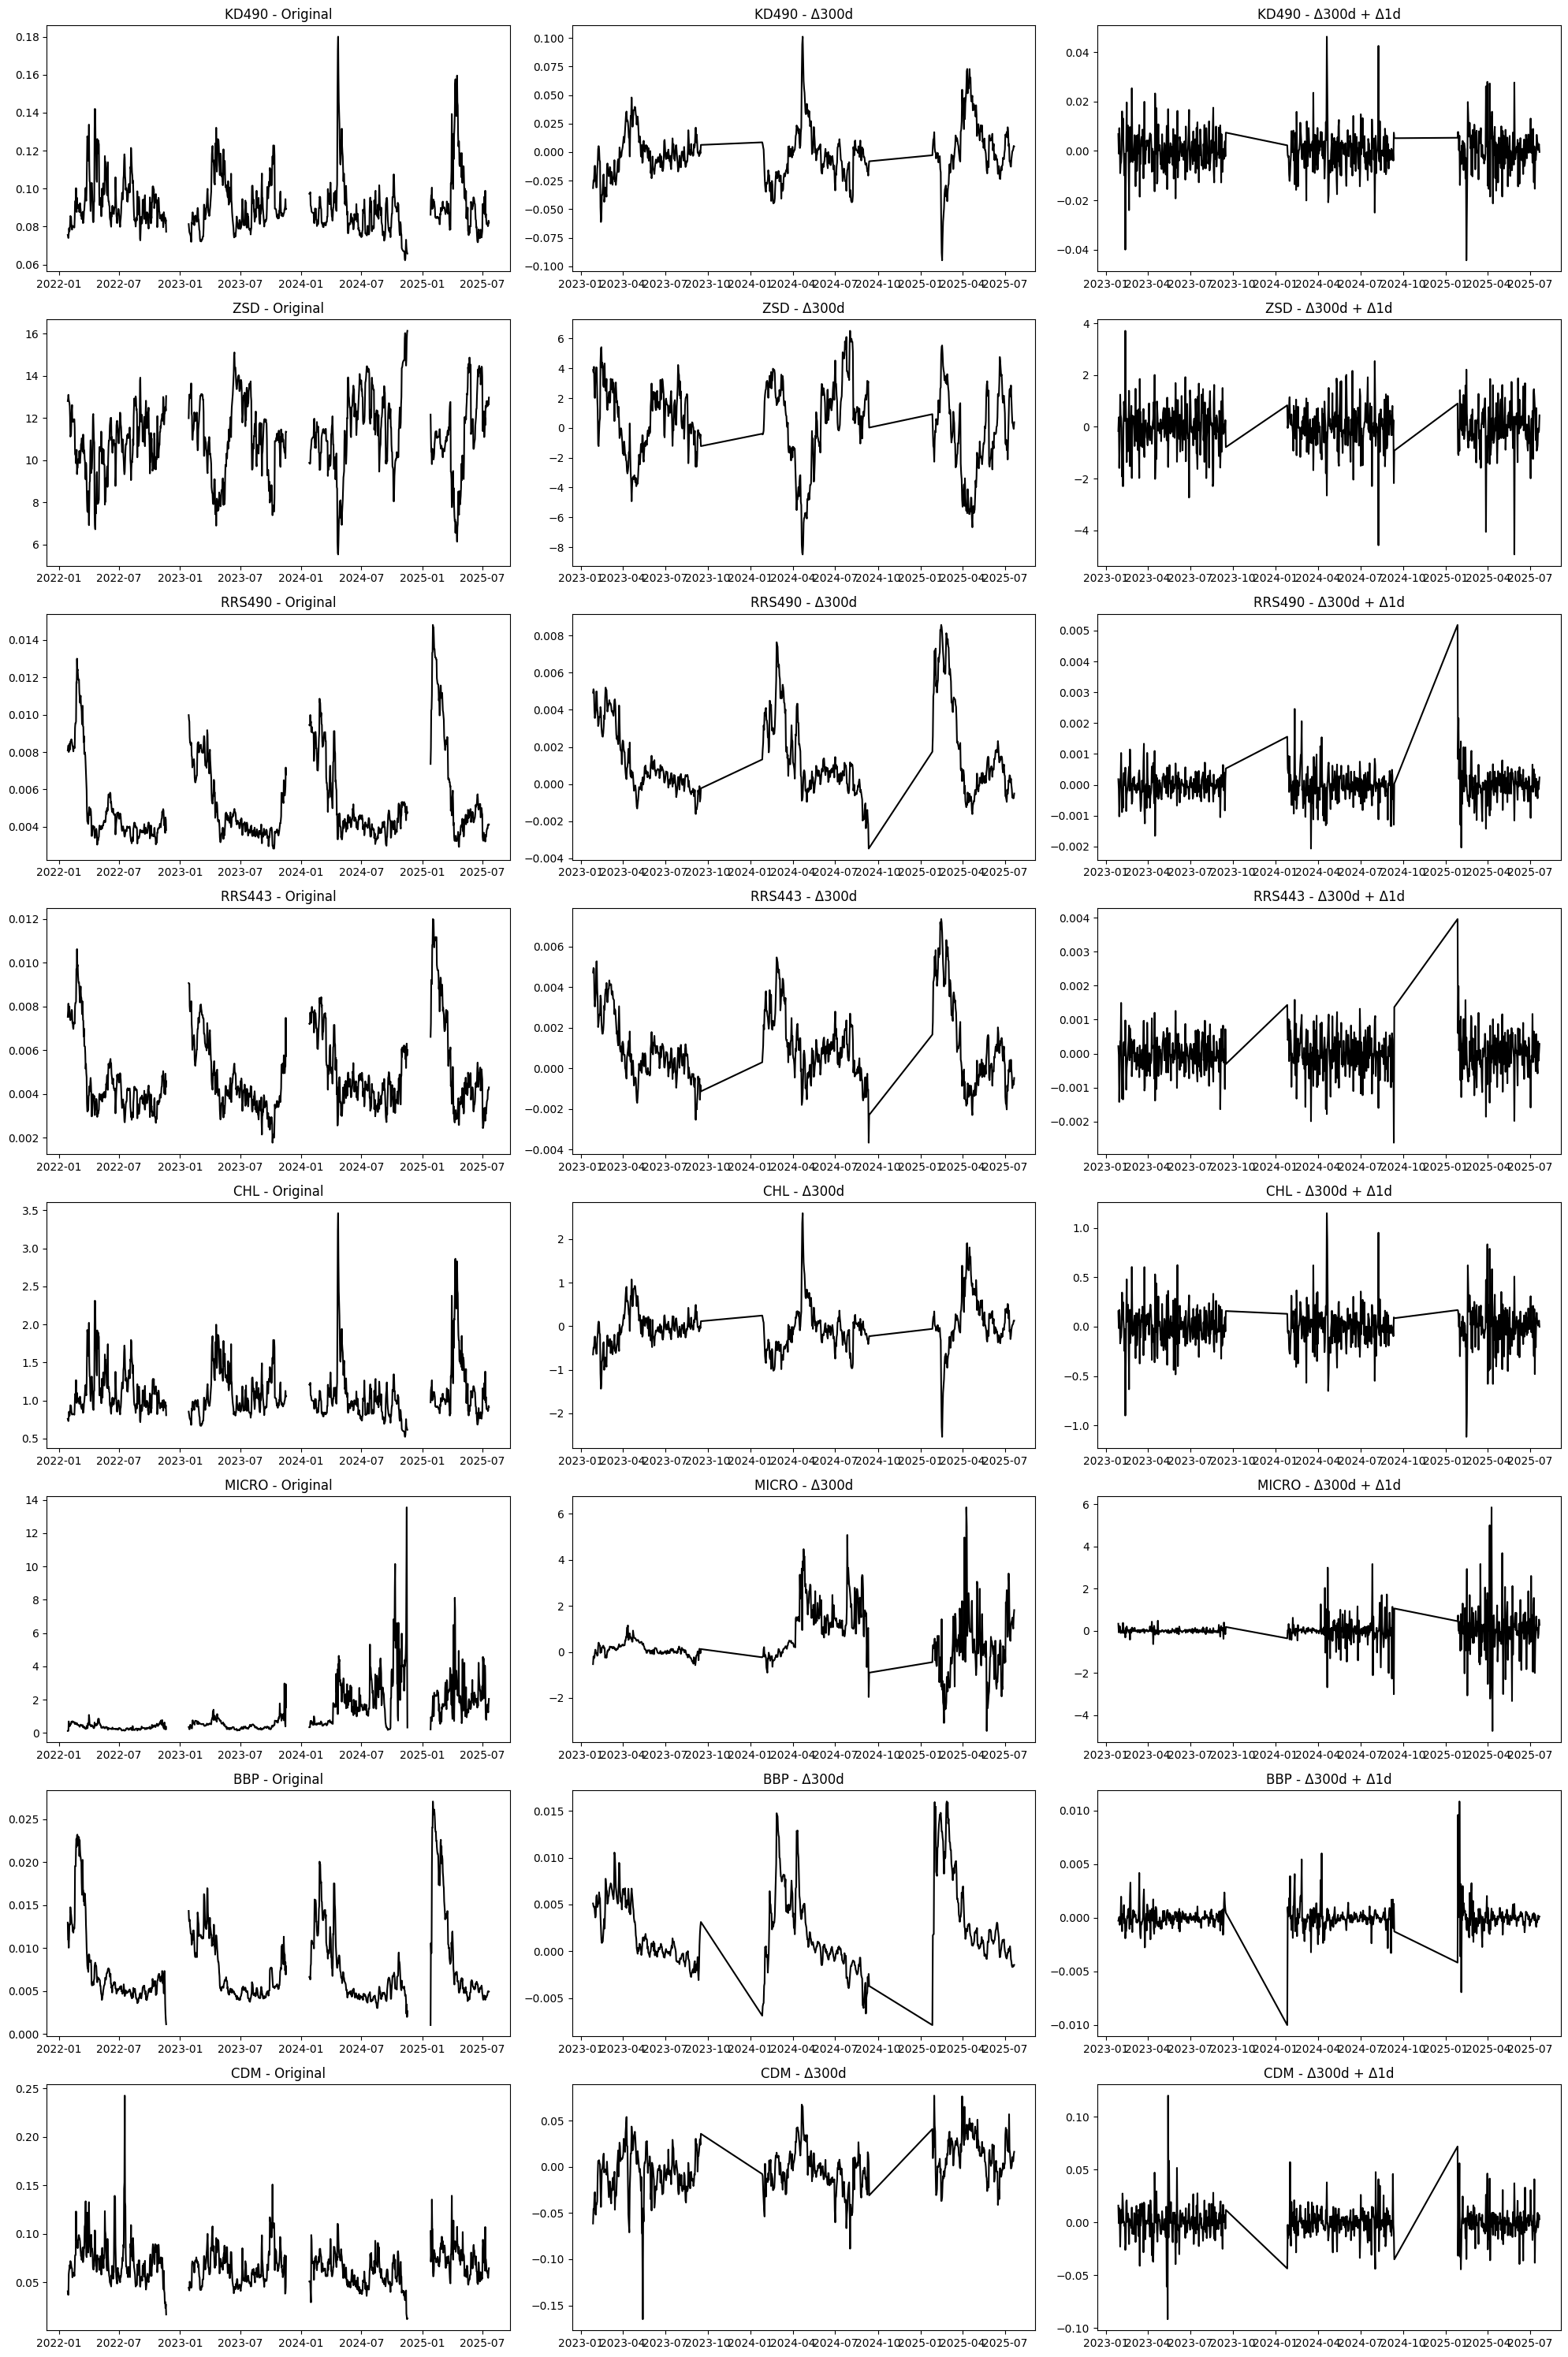

In [ ]:
# Create 8x3 grid for time series transformations
fig1, axes1 = plt.subplots(8, 3, figsize=(20, 30))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, param in enumerate(parameter_columns):
    # Original series
    ts = data[param].resample('D').mean()
    axes1[i, 0].plot(ts, color='black')
    axes1[i, 0].set_title(f'{param} - Original')
    axes1[i, 0].grid(False)

    # Seasonally differenced (300 days)
    ts_diff1 = ts.diff(300).dropna()
    axes1[i, 1].plot(ts_diff1, color='black')
    axes1[i, 1].set_title(f'{param} - Δ300d')
    axes1[i, 1].grid(False)

    # Doubly differenced (300-day + 1-day)
    ts_diff2 = ts_diff1.diff().dropna()
    axes1[i, 2].plot(ts_diff2, color='black')
    axes1[i, 2].set_title(f'{param} - Δ300d + Δ1d')
    axes1[i, 2].grid(False)

plt.tight_layout()
plt.show()

## ACF / PACF plots

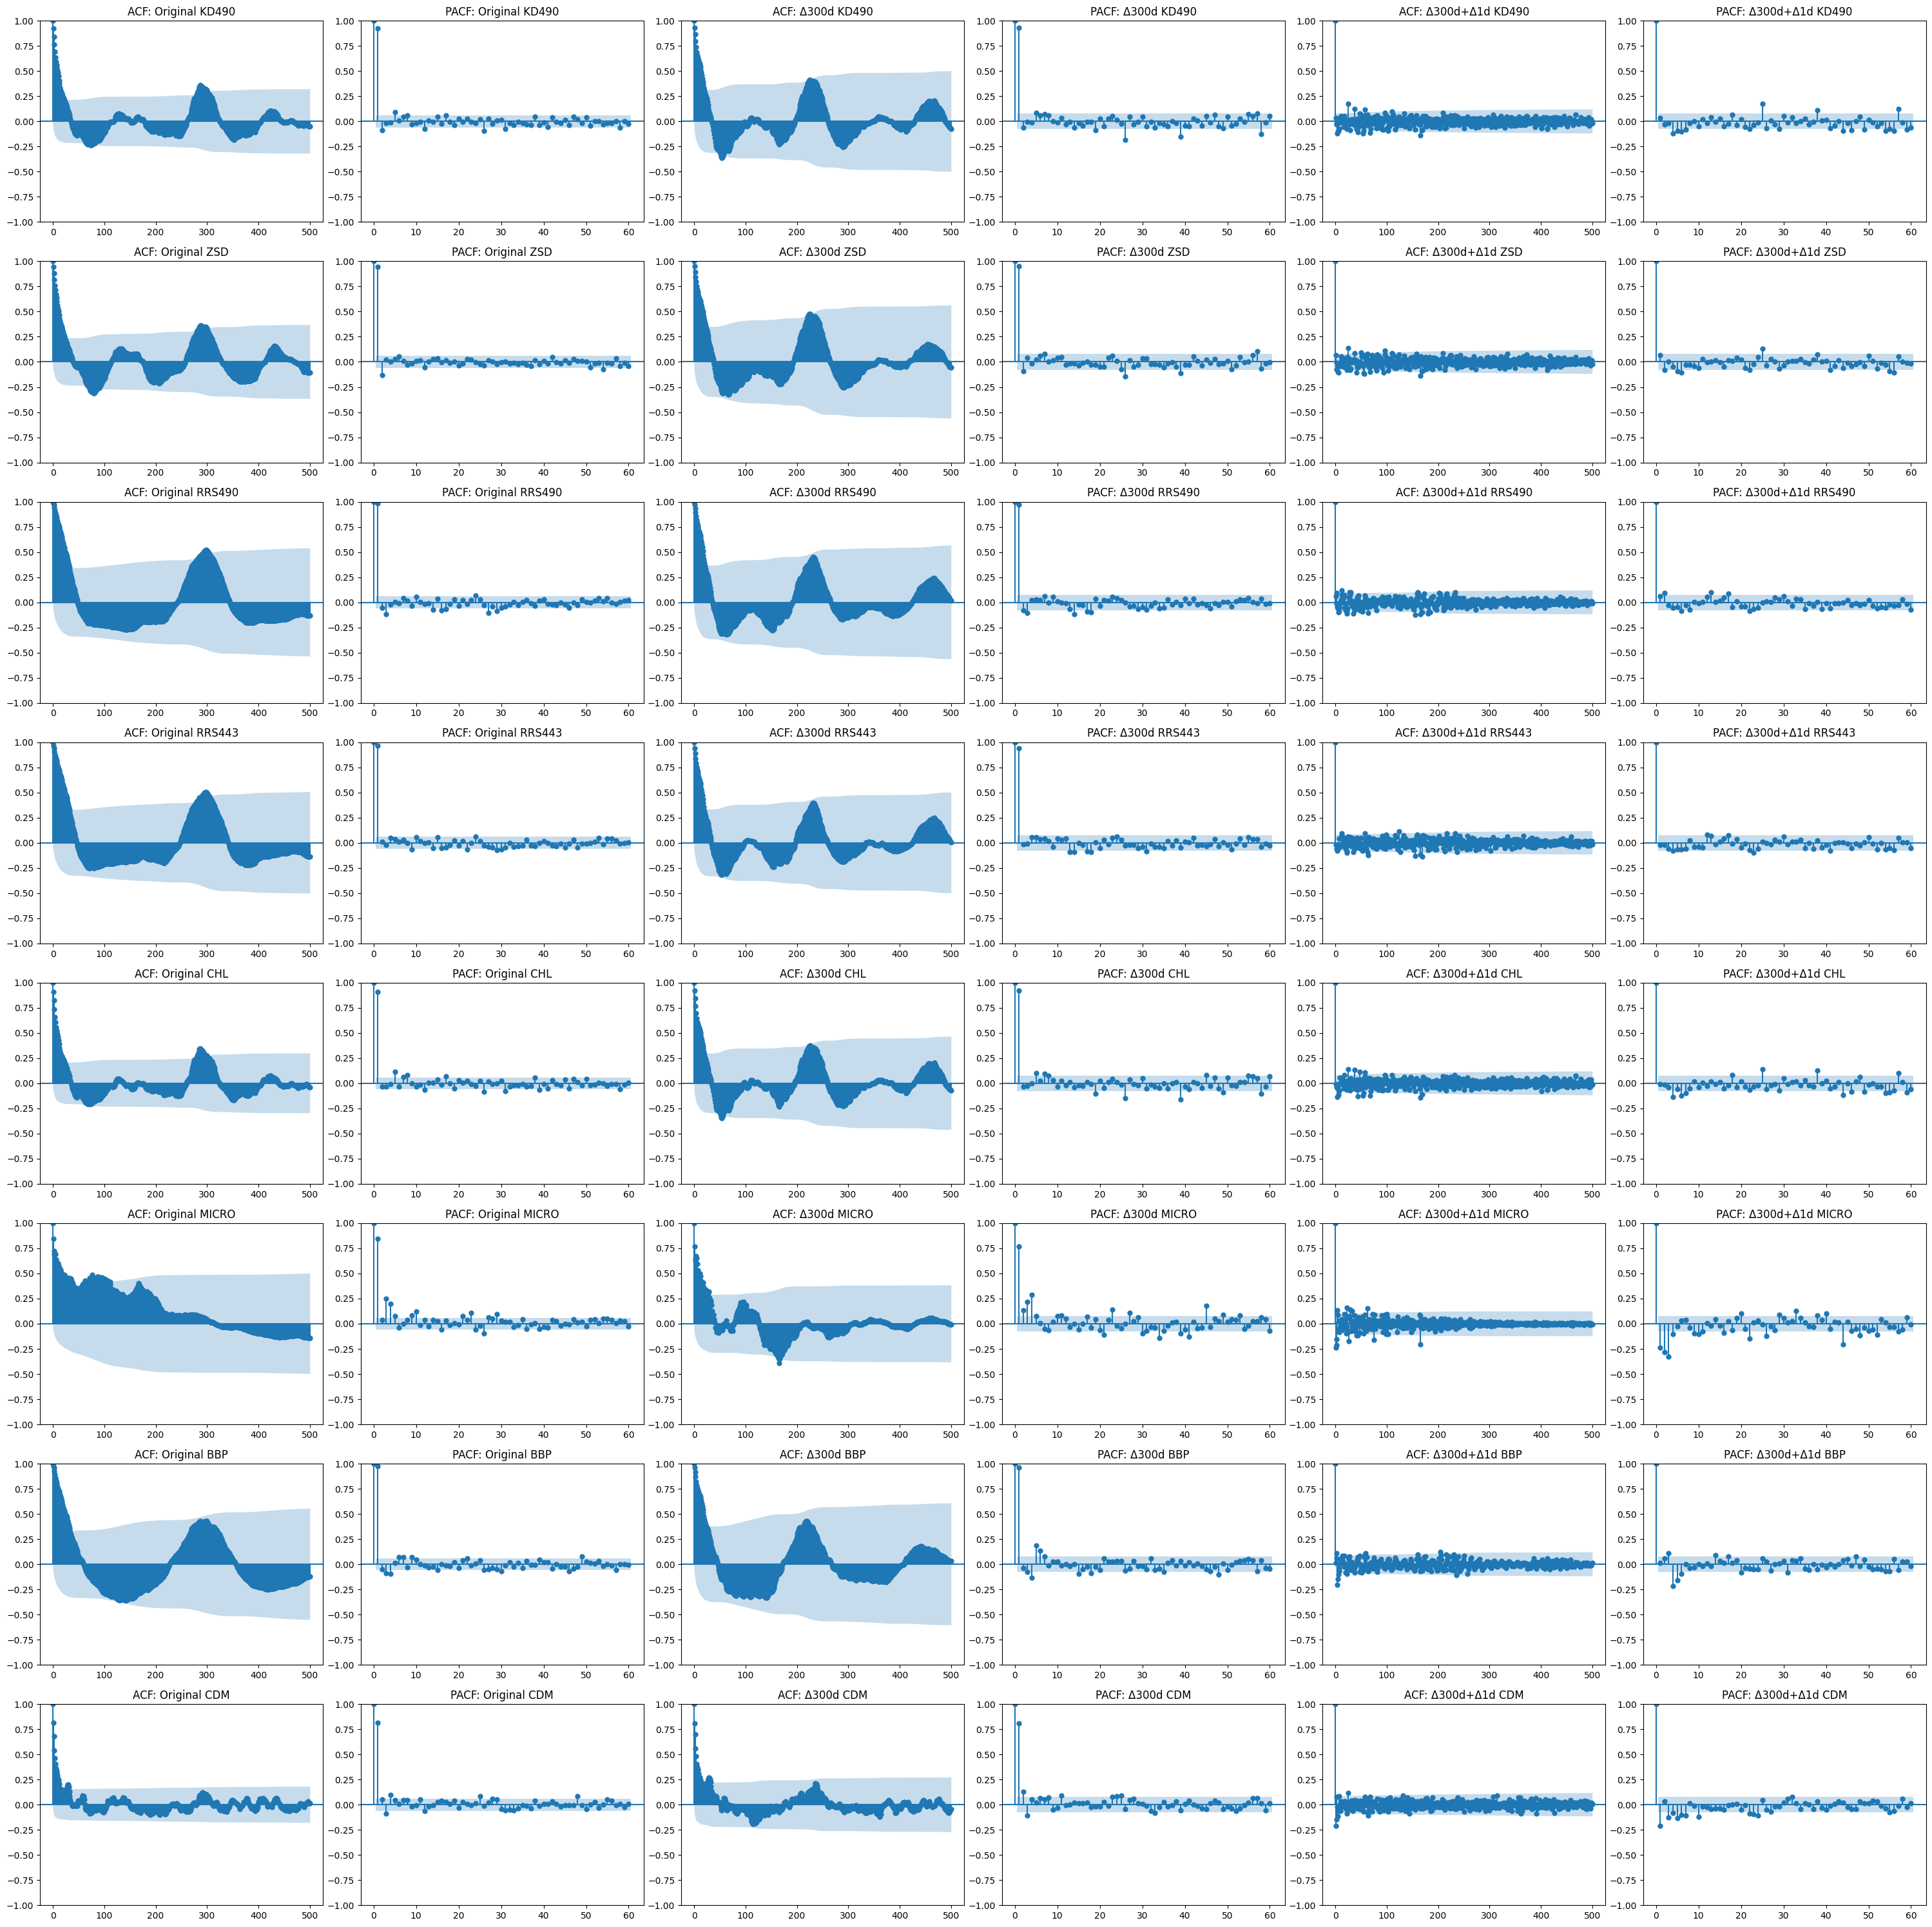

In [ ]:
# Create 8x6 grid for diagnostics (each variable gets 3x ACF + 3x PACF)
fig2, axes2 = plt.subplots(8, 6, figsize=(30, 30))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, param in enumerate(parameter_columns):
    ts = data[param].resample('D').mean()
    ts_diff1 = ts.diff(300).dropna()
    ts_diff2 = ts_diff1.diff().dropna()

    # Original series diagnostics
    plot_acf(ts.dropna(), lags=500, ax=axes2[i, 0], alpha=0.05)
    axes2[i, 0].set_title(f'ACF: Original {param}')
    plot_pacf(ts.dropna(), lags=60, ax=axes2[i, 1], alpha=0.05, method='ywm')
    axes2[i, 1].set_title(f'PACF: Original {param}')

    # Seasonally differenced diagnostics
    plot_acf(ts_diff1, lags=500, ax=axes2[i, 2], alpha=0.05)
    axes2[i, 2].set_title(f'ACF: Δ300d {param}')
    plot_pacf(ts_diff1, lags=60, ax=axes2[i, 3], alpha=0.05, method='ywm')
    axes2[i, 3].set_title(f'PACF: Δ300d {param}')

    # Doubly differenced diagnostics
    plot_acf(ts_diff2, lags=500, ax=axes2[i, 4], alpha=0.05)
    axes2[i, 4].set_title(f'ACF: Δ300d+Δ1d {param}')
    plot_pacf(ts_diff2, lags=60, ax=axes2[i, 5], alpha=0.05, method='ywm')
    axes2[i, 5].set_title(f'PACF: Δ300d+Δ1d {param}')

plt.tight_layout()
plt.show()

## Case Study for variable RRS443: Time Series, ACF/PACF Plots

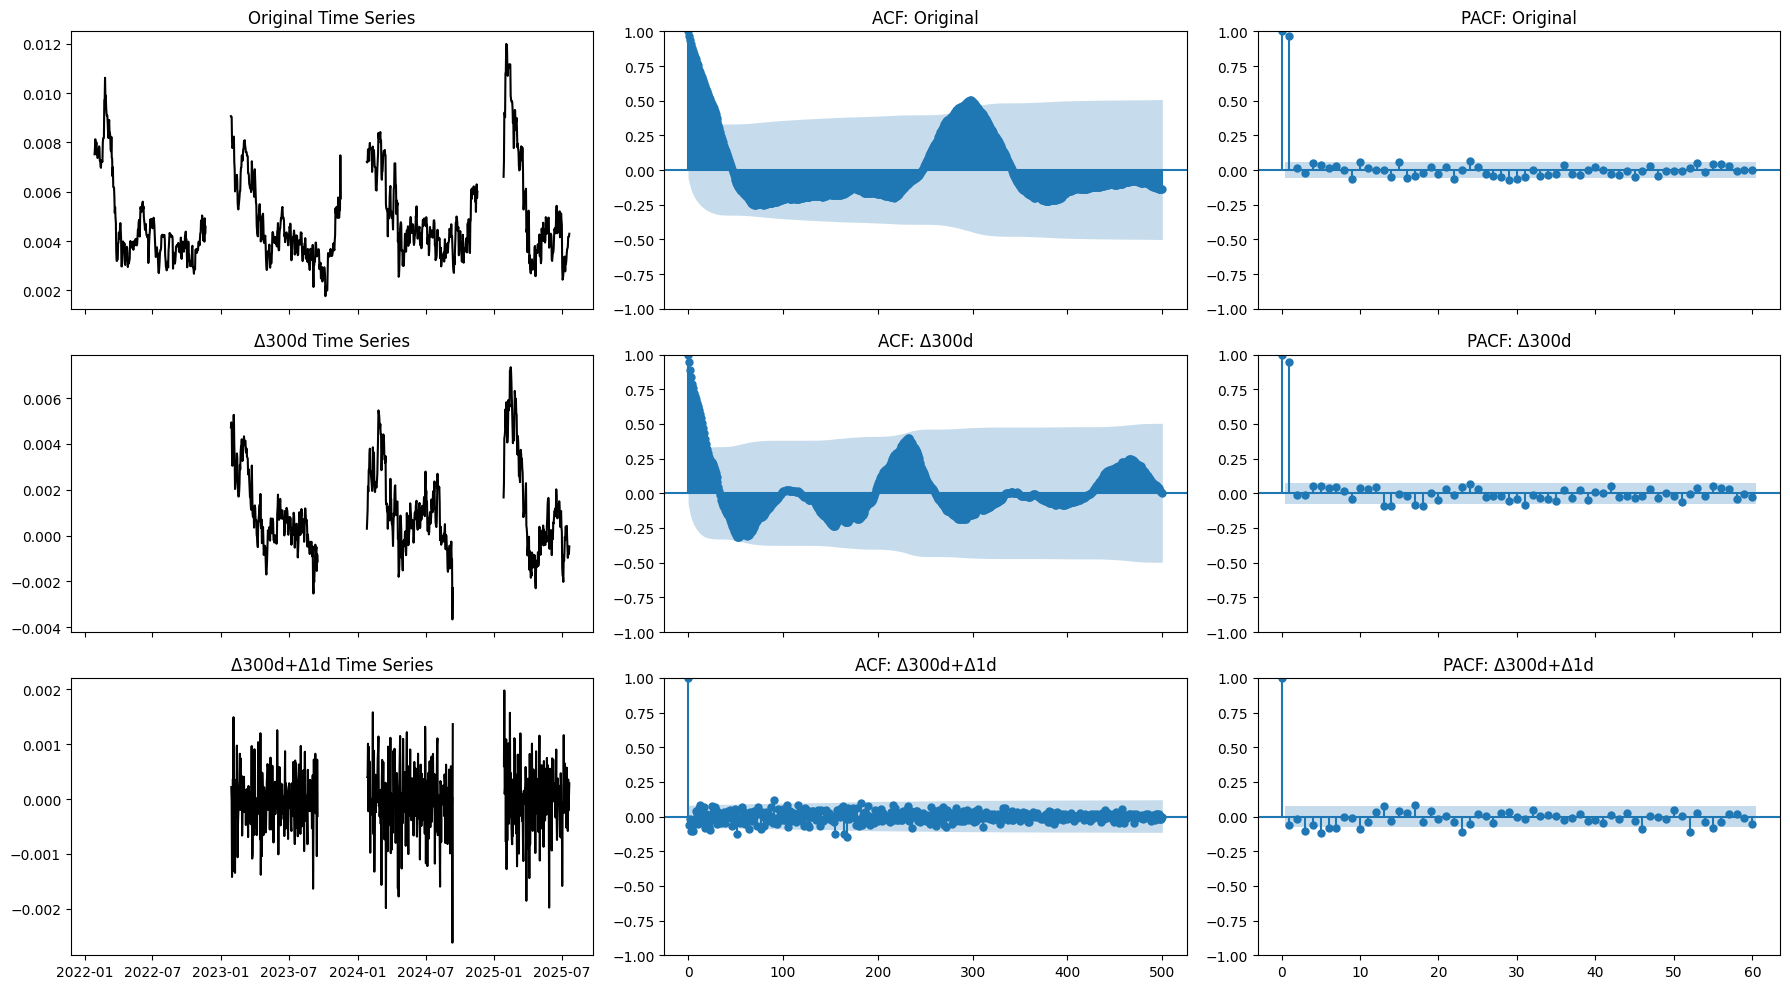

In [ ]:
ts = data["RRS443"].resample('D').mean()
ts_diff1 = ts.diff(300)  # keep NaNs for plotting gaps
ts_diff2 = ts_diff1.diff()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10), sharex='col')
transformations = ['Original', 'Δ300d', 'Δ300d+Δ1d']
series_list = [ts, ts_diff1, ts_diff2]

for i, (label, series) in enumerate(zip(transformations, series_list)):
    # Time Series Plot (markers instead of connecting lines)
    axes[i, 0].plot(series.index, series.values, color='black')
    axes[i, 0].set_title(f"{label} Time Series")

    # ACF
    plot_acf(series.dropna(), ax=axes[i, 1], lags=500)
    axes[i, 1].set_title(f"ACF: {label}")

    # PACF
    plot_pacf(series.dropna(), ax=axes[i, 2], lags=60, alpha=0.05)
    axes[i, 2].set_title(f"PACF: {label}")

plt.tight_layout()
plt.show()

## Similar plots created and saved for all variables

In [ ]:
# Folder to store plots
output_dir = "time_series_plots"
os.makedirs(output_dir, exist_ok=True)

for param in parameter_columns:
    ts = data[param].resample('D').mean()
    ts_diff1 = ts.diff(300)  # keep NaNs for plotting gaps
    ts_diff2 = ts_diff1.diff()

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10), sharex='col')

    transformations = ['Original', 'Δ300d', 'Δ300d+Δ1d']
    series_list = [ts, ts_diff1, ts_diff2]

    for i, (label, series) in enumerate(zip(transformations, series_list)):
        # Time Series Plot (preserve NaNs so no connecting lines)
        axes[i, 0].plot(series.index, series.values, color='black')
        axes[i, 0].set_title(f"{label} Time Series")

        # ACF
        plot_acf(series.dropna(), ax=axes[i, 1], lags=500)
        axes[i, 1].set_title(f"ACF: {label}")

        # PACF
        plot_pacf(series.dropna(), ax=axes[i, 2], lags=60, alpha=0.05)
        axes[i, 2].set_title(f"PACF: {label}")

    plt.tight_layout()
    file_path = os.path.join(output_dir, f"{param}_timeseries_acf_pacf.png")
    plt.savefig(file_path, dpi=300, bbox_inches='tight')  # High quality
    plt.close(fig)

print(f"✅ Saved all plots in '{output_dir}' as high-quality PNGs.")

✅ Saved all plots in 'time_series_plots' as high-quality PNGs.


# First differencing + second differencing

## Series Plots

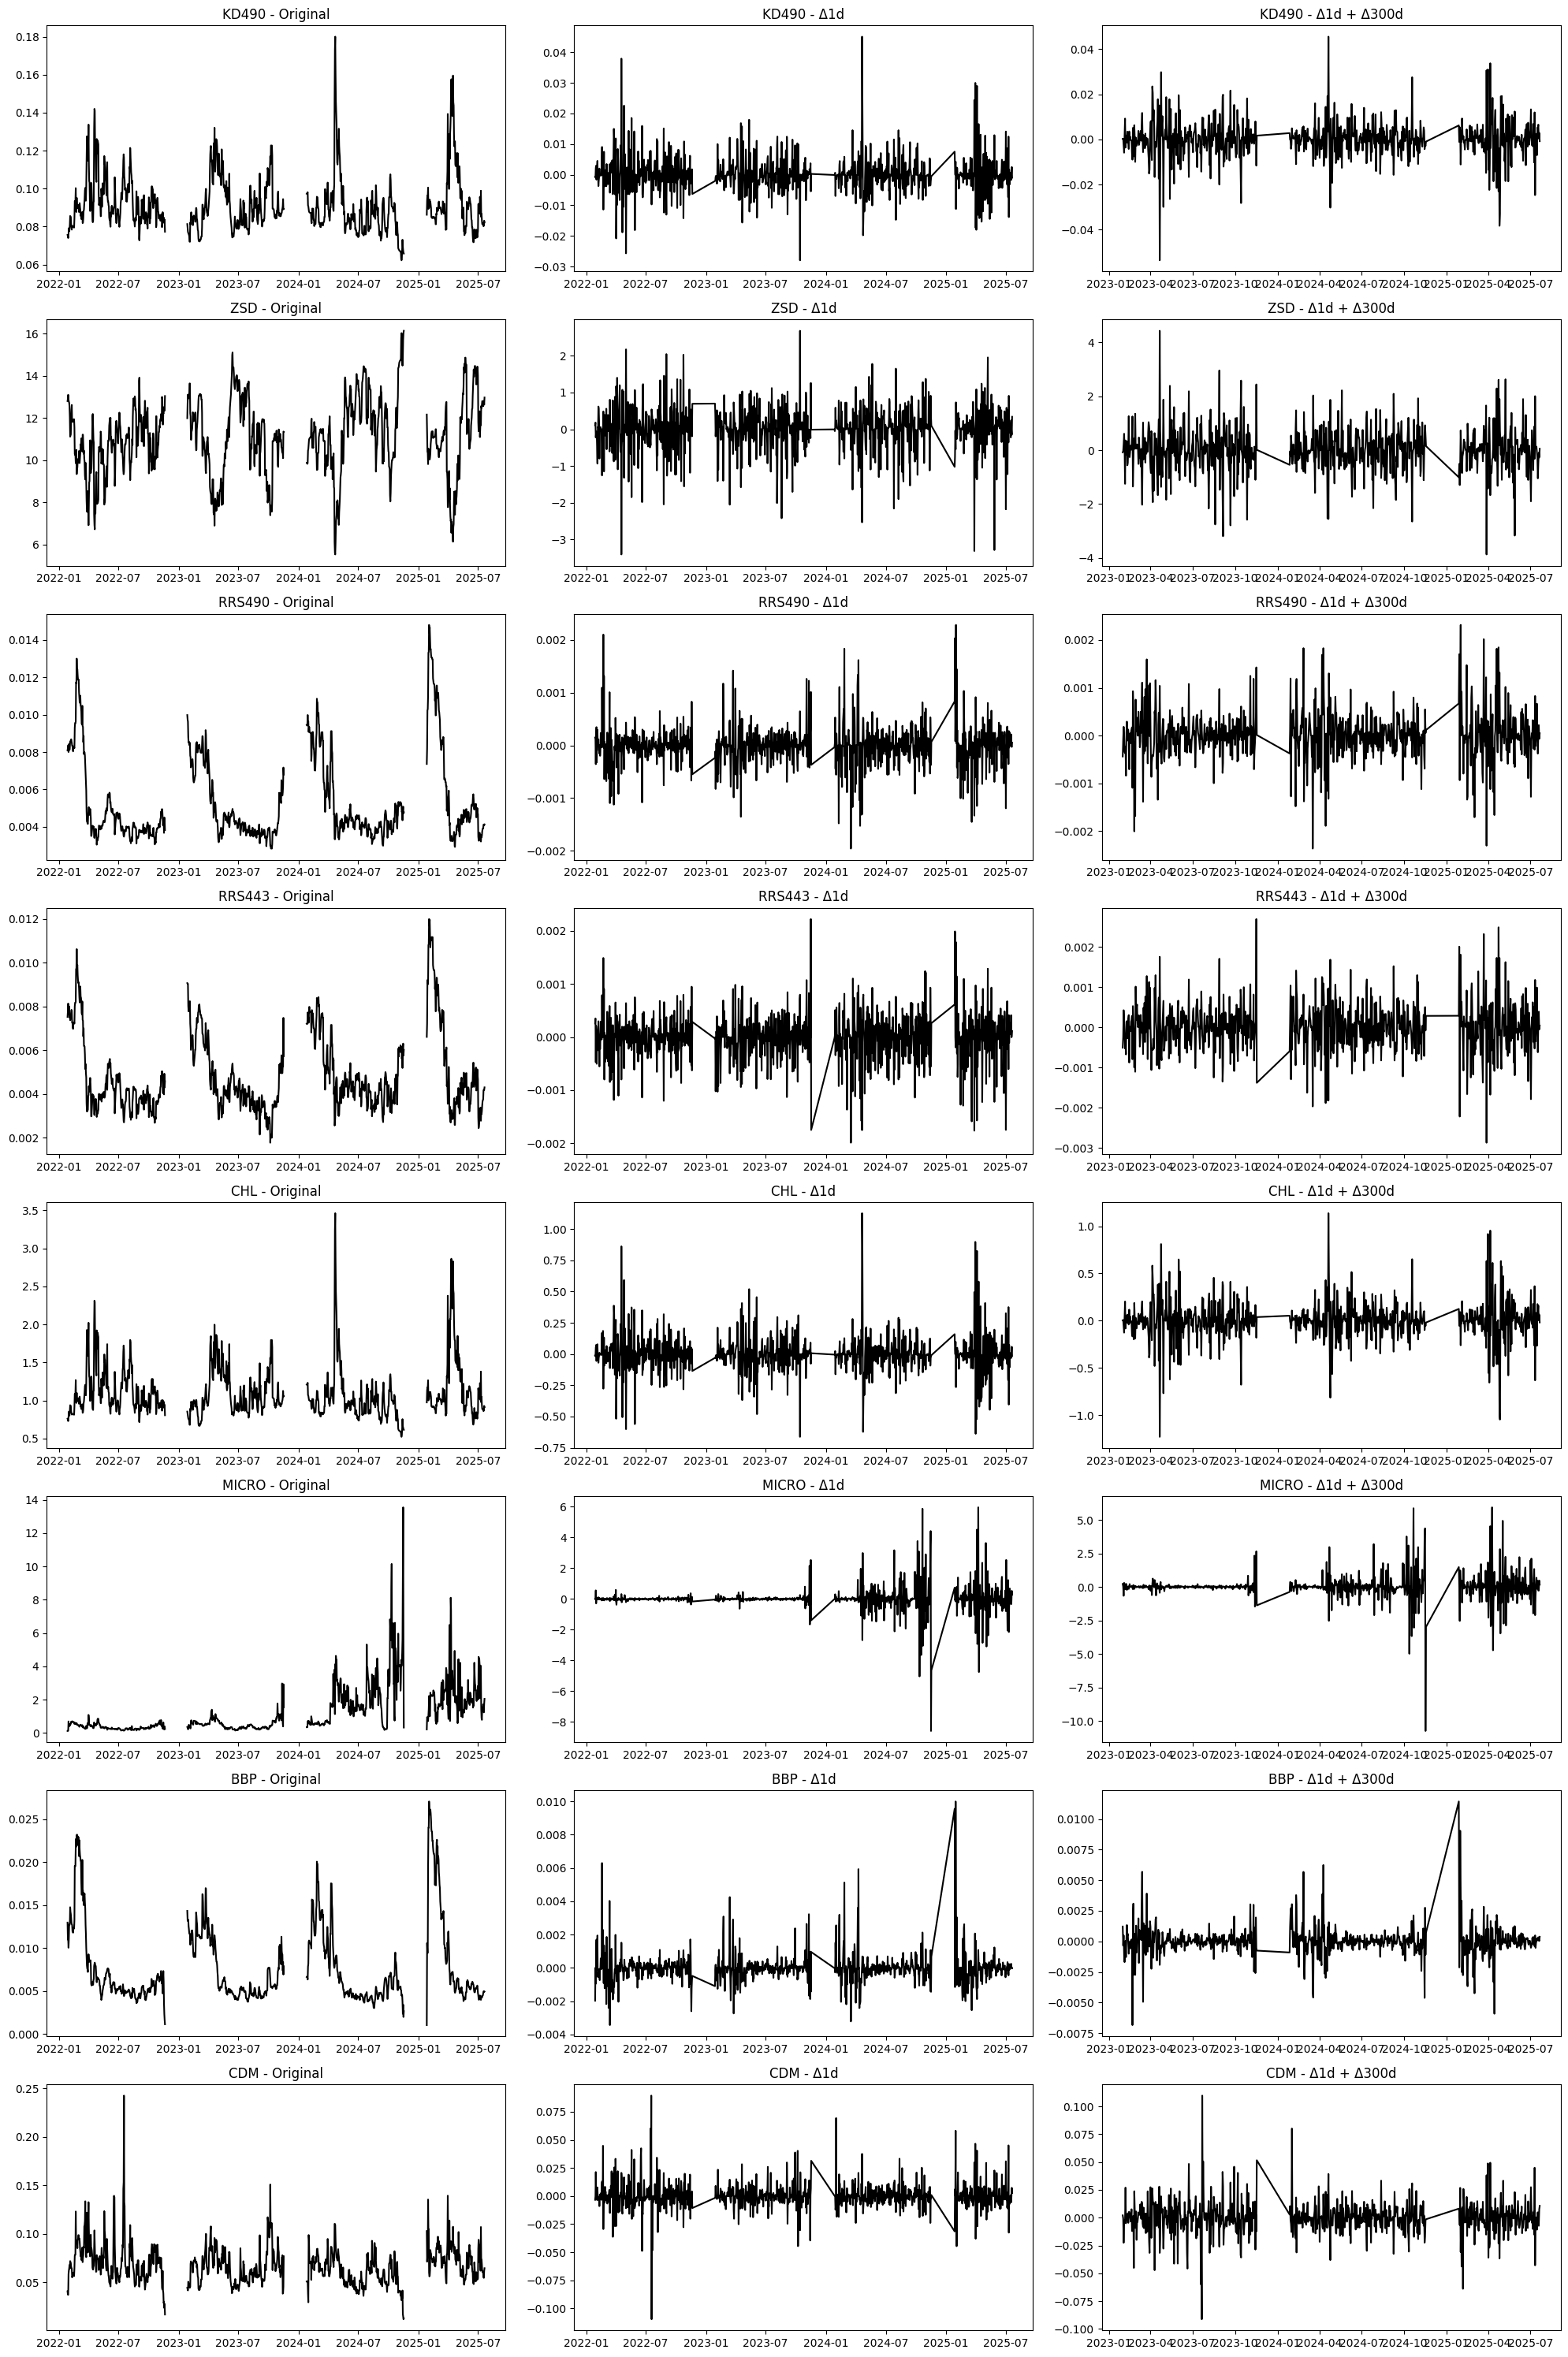

In [ ]:
# Parameters
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

# Create 8x3 grid for time series transformations
fig1, axes1 = plt.subplots(8, 3, figsize=(20, 30))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, param in enumerate(parameter_columns):
    # Original series
    ts = data[param].resample('D').mean()
    axes1[i, 0].plot(ts, color='black')
    axes1[i, 0].set_title(f'{param} - Original')
    axes1[i, 0].grid(False)

    # Seasonally differenced (300 days)
    ts_diff1 = ts.diff().dropna()
    axes1[i, 1].plot(ts_diff1, color='black')
    axes1[i, 1].set_title(f'{param} - Δ1d')
    axes1[i, 1].grid(False)

    # Doubly differenced (300-day + 1-day)
    ts_diff2 = ts_diff1.diff(300).dropna()
    axes1[i, 2].plot(ts_diff2, color='black')
    axes1[i, 2].set_title(f'{param} - Δ1d + Δ300d')
    axes1[i, 2].grid(False)

plt.tight_layout()
plt.show()

## ACF / PACF plots

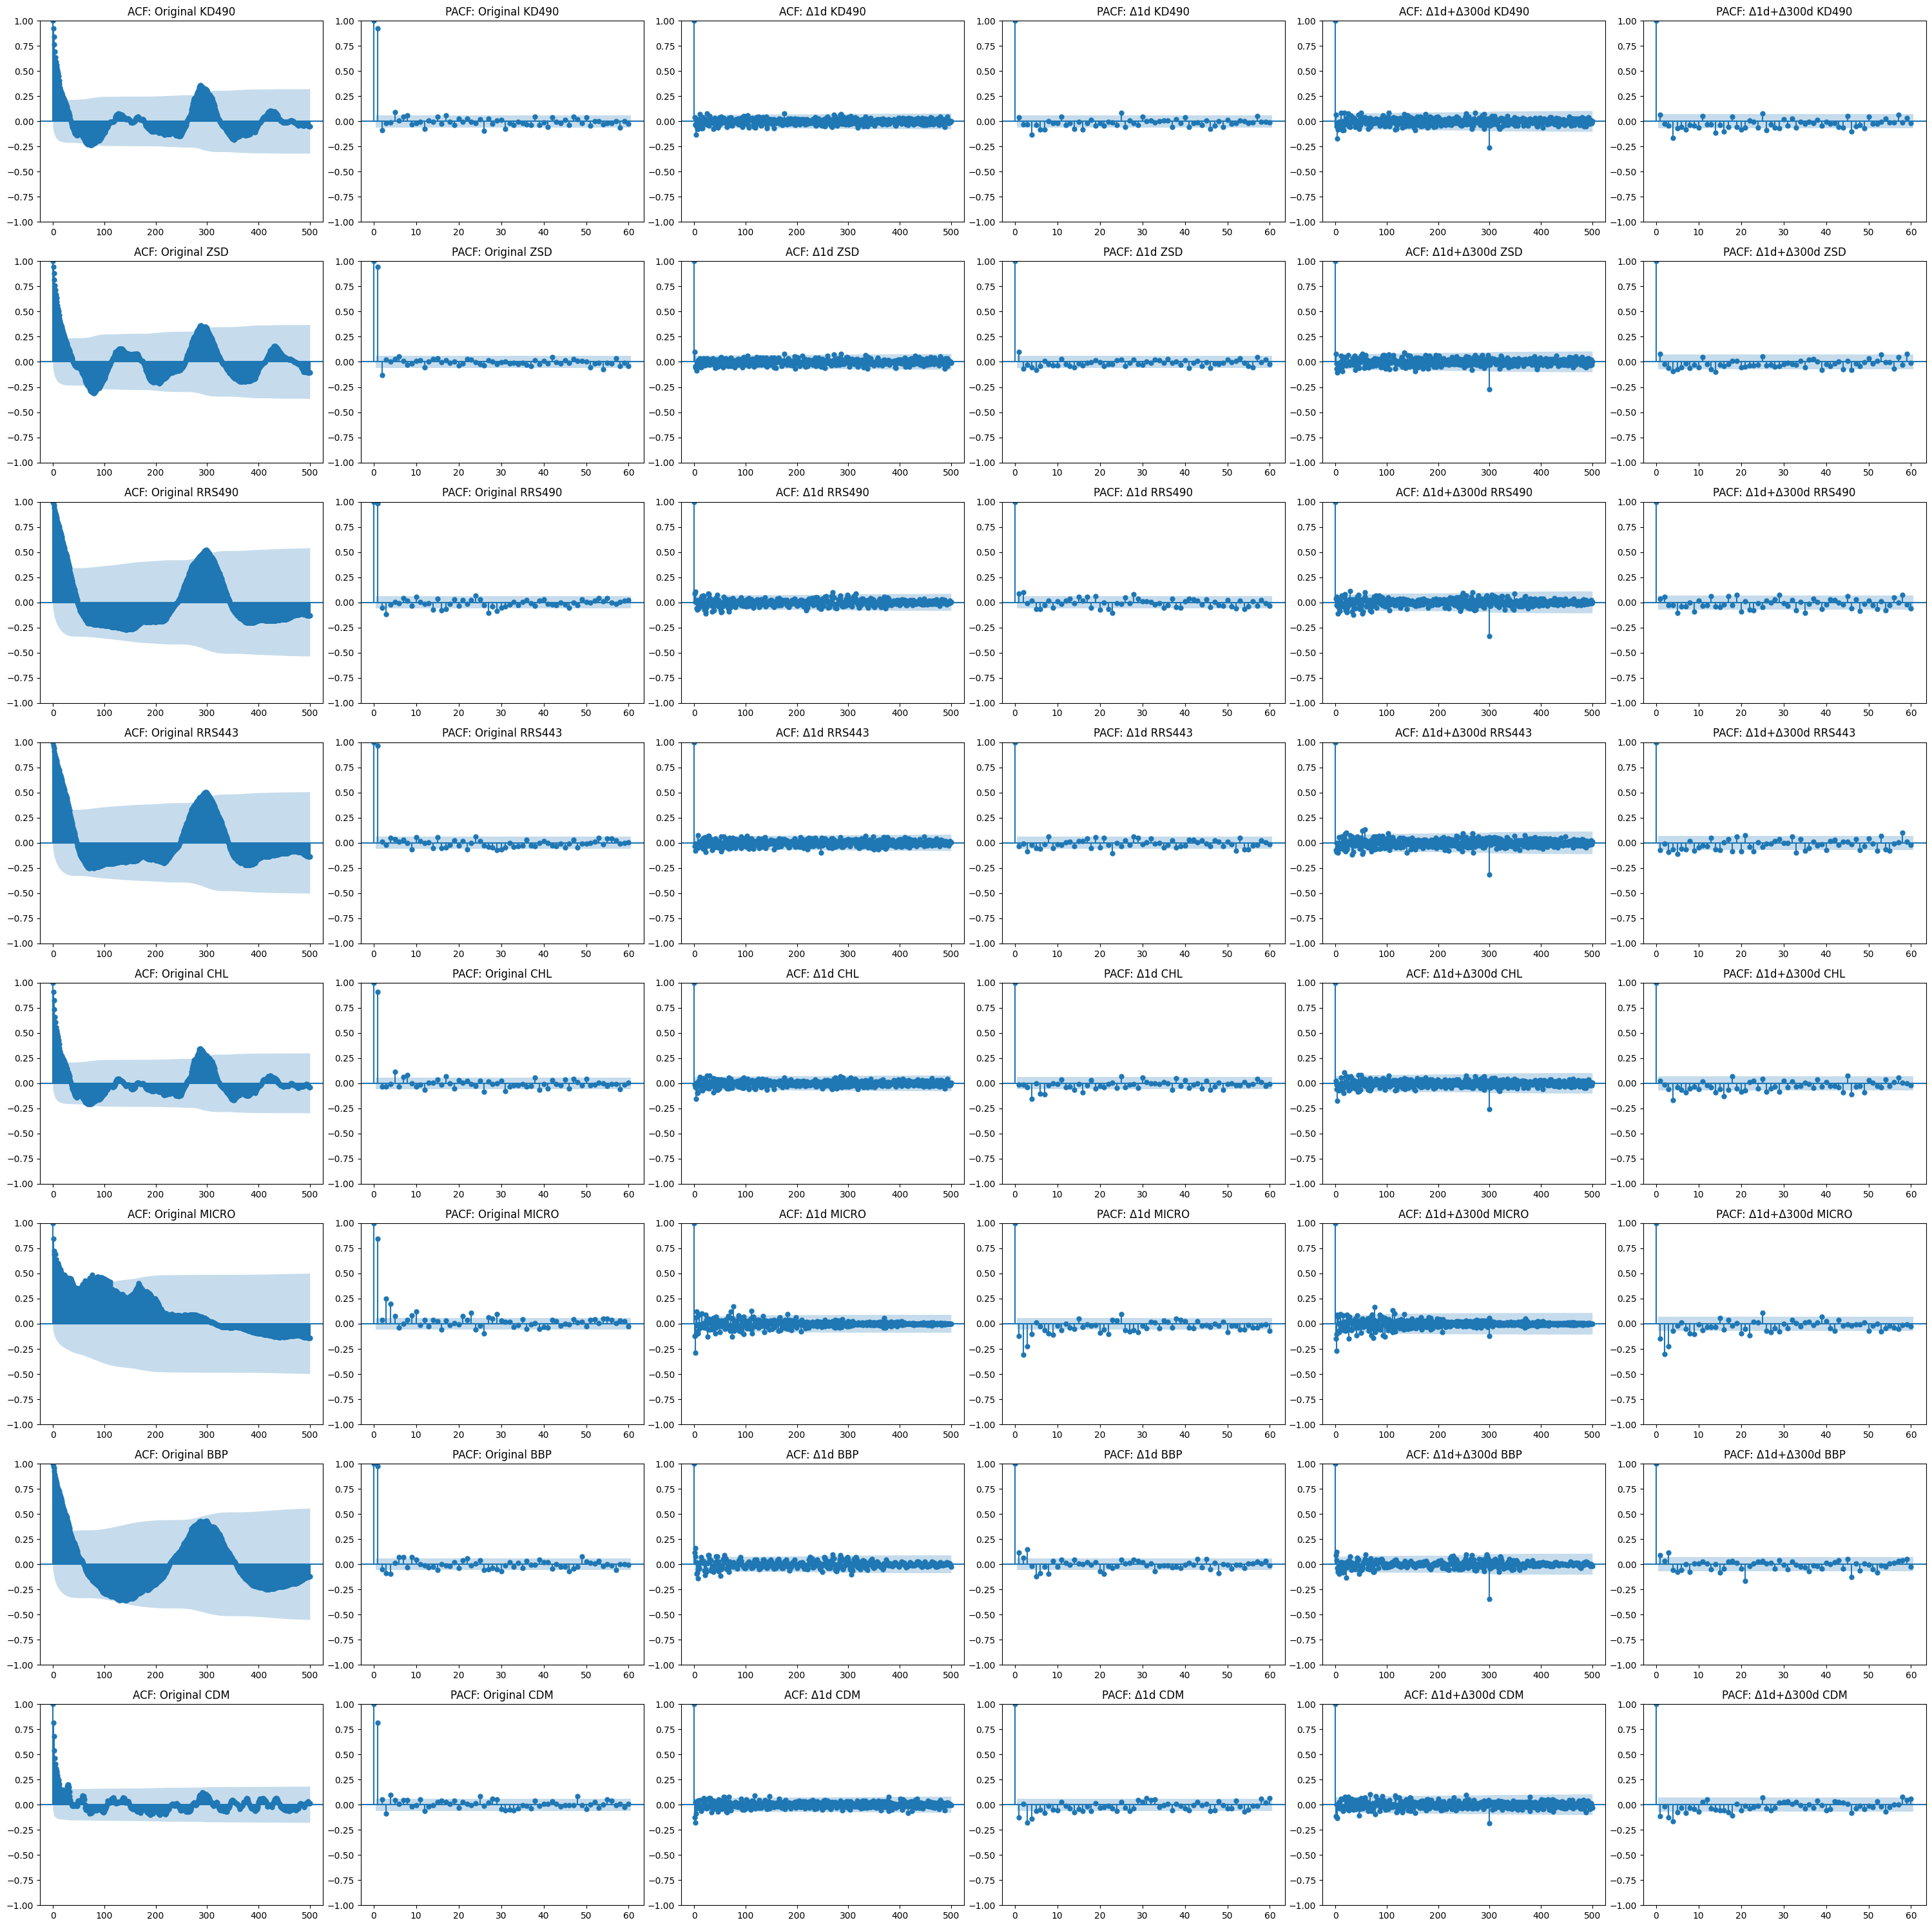

In [ ]:
# Create 8x6 grid for diagnostics (each variable gets 3x ACF + 3x PACF)
fig2, axes2 = plt.subplots(8, 6, figsize=(30, 30))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, param in enumerate(parameter_columns):
    ts = data[param].resample('D').mean()
    ts_diff1 = ts.diff().dropna()
    ts_diff2 = ts_diff1.diff(300).dropna()

    # Original series diagnostics
    plot_acf(ts.dropna(), lags=500, ax=axes2[i, 0], alpha=0.05)
    axes2[i, 0].set_title(f'ACF: Original {param}')
    plot_pacf(ts.dropna(), lags=60, ax=axes2[i, 1], alpha=0.05, method='ywm')
    axes2[i, 1].set_title(f'PACF: Original {param}')

    # Seasonally differenced diagnostics
    plot_acf(ts_diff1, lags=500, ax=axes2[i, 2], alpha=0.05)
    axes2[i, 2].set_title(f'ACF: Δ1d {param}')
    plot_pacf(ts_diff1, lags=60, ax=axes2[i, 3], alpha=0.05, method='ywm')
    axes2[i, 3].set_title(f'PACF: Δ1d {param}')

    # Doubly differenced diagnostics
    plot_acf(ts_diff2, lags=500, ax=axes2[i, 4], alpha=0.05)
    axes2[i, 4].set_title(f'ACF: Δ1d+Δ300d {param}')
    plot_pacf(ts_diff2, lags=60, ax=axes2[i, 5], alpha=0.05, method='ywm')
    axes2[i, 5].set_title(f'PACF: Δ1d+Δ300d {param}')

plt.tight_layout()
plt.show()

## Case Study for variable RRS443: Time Series, ACF/PACF Plots

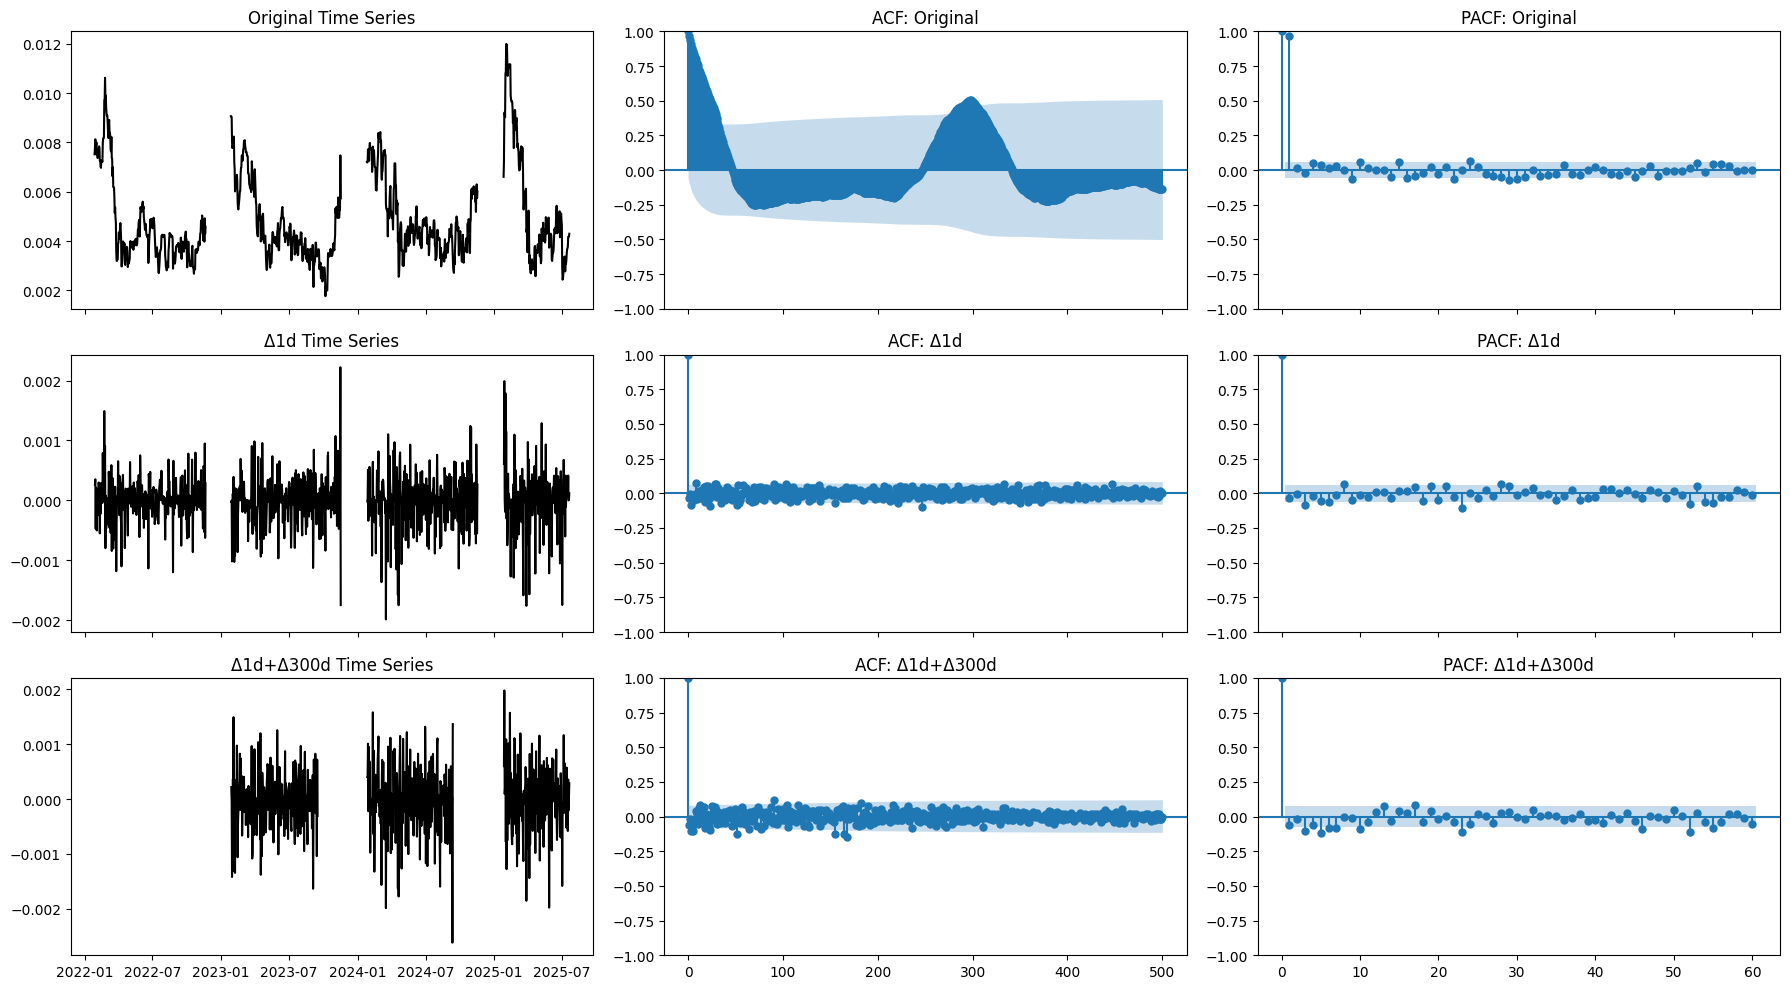

In [ ]:
ts = data["RRS443"].resample('D').mean()
ts_diff1 = ts.diff()  # keep NaNs for plotting gaps
ts_diff2 = ts_diff1.diff(300)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10), sharex='col')
transformations = ['Original', 'Δ1d', 'Δ1d+Δ300d']
series_list = [ts, ts_diff1, ts_diff2]

for i, (label, series) in enumerate(zip(transformations, series_list)):

    # Time Series Plot (markers instead of connecting lines)
    axes[i, 0].plot(series.index, series.values, color='black')
    axes[i, 0].set_title(f"{label} Time Series")

    # ACF
    plot_acf(series.dropna(), ax=axes[i, 1], lags=500)
    axes[i, 1].set_title(f"ACF: {label}")

    # PACF
    plot_pacf(series.dropna(), ax=axes[i, 2], lags=60, alpha=0.05)
    axes[i, 2].set_title(f"PACF: {label}")

plt.tight_layout()
plt.show()

## Similar plots created and saved for all variables

In [ ]:
# Folder to store plots
output_dir = "Seasonality2"
os.makedirs(output_dir, exist_ok=True)

for param in parameter_columns:
    ts = data[param].resample('D').mean()
    ts_diff1 = ts.diff()  # keep NaNs for plotting gaps
    ts_diff2 = ts_diff1.diff()

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10), sharex='col')

    transformations = ['Original', 'Δ1d', 'Δ1d+Δ300d']
    series_list = [ts, ts_diff1, ts_diff2]

    for i, (label, series) in enumerate(zip(transformations, series_list)):
        # Time Series Plot (preserve NaNs so no connecting lines)
        axes[i, 0].plot(series.index, series.values, color='black')
        axes[i, 0].set_title(f"{label} Time Series")

        # ACF
        plot_acf(series.dropna(), ax=axes[i, 1], lags=500)
        axes[i, 1].set_title(f"ACF: {label}")

        # PACF
        plot_pacf(series.dropna(), ax=axes[i, 2], lags=60, alpha=0.05)
        axes[i, 2].set_title(f"PACF: {label}")

    plt.tight_layout()
    file_path = os.path.join(output_dir, f"{param}_timeseries_acf_pacf.png")
    plt.savefig(file_path, dpi=300, bbox_inches='tight')  # High quality
    plt.close(fig)

print(f"Saved all plots in '{output_dir}' as high-quality PNGs.")

Saved all plots in 'Seasonality2' as high-quality PNGs.


# Tests for stationarity

In [ ]:
def adf_test(timeseries):
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(timeseries, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"  {key}: {val:.4f}")
    if result[1] < 0.05:
        print("=> Reject null hypothesis (stationary)")
    else:
        print("=> Fail to reject null hypothesis (non-stationary)")

def kpss_test(timeseries, regression='c'):
    print("\nKPSS Test:")
    statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")
    print(f"KPSS Statistic: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print("Critical Values:")
    for key, val in critical_values.items():
        print(f"  {key}: {val:.4f}")
    if p_value < 0.05:
        print("=> Reject null hypothesis (non-stationary)")
    else:
        print("=> Do not reject null hypothesis (stationary)")

In [ ]:
for param in parameter_columns:
    print(f"\n{param}")
    ts = data[param].resample('D').mean().dropna()
    # Example: seasonal difference + first difference
    diff = ts.diff().dropna()
    diff_seasonal = ts.diff(300).dropna()
    diff_seasonal_first = diff_seasonal.diff().dropna()

# Then rerun ADF and KPSS on diff_seasonal_first
    adf_test(ts)
    kpss_test(ts)


KD490
Augmented Dickey-Fuller Test:
ADF Statistic: -6.0130
p-value: 0.0000
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.1054
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

ZSD


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -6.1379
p-value: 0.0000
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.2763
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

RRS490


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -3.6775
p-value: 0.0044
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.1036
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

RRS443


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -4.1969
p-value: 0.0007
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.1041
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

CHL


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -5.2049
p-value: 0.0000
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.0697
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

MICRO


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -2.5355
p-value: 0.1071
Critical Values:
  1%: -3.4366
  5%: -2.8643
  10%: -2.5682
=> Fail to reject null hypothesis (non-stationary)

KPSS Test:
KPSS Statistic: 3.3754
p-value: 0.0100
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Reject null hypothesis (non-stationary)

BBP


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -3.4485
p-value: 0.0094
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.1338
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)

CDM


/tmp/ipython-input-1673084055.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, regression=regression, nlags="auto")


Augmented Dickey-Fuller Test:
ADF Statistic: -7.8886
p-value: 0.0000
Critical Values:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682
=> Reject null hypothesis (stationary)

KPSS Test:
KPSS Statistic: 0.3743
p-value: 0.0882
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
=> Do not reject null hypothesis (stationary)
